In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


In [ ]:
X = ((X / 255.) - .5) * 2

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

<br>
<br>

## Implementing a multi-layer perceptron

In [ ]:
import numpy as np

In [ ]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        # h1 weight initialization
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)

        # h2 weights initialization
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h2 = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer 1
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        # Input dim: [n_examples, n_hidden]
        # output dim: [n_examples, n_hidden]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder", loss wrt zout.

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h1

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out) # dl/dz * dz/dw = dl/dw
        d_loss__db_out = np.sum(delta_out, axis=0) # dz/db = 1


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h2 = self.weight_out # dzout/dah2

        # output dim: [n_examples, n_hidden]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2) # dl/dz * dz/dah = dl/dah

        # [n_examples, n_hidden]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h2__d_w_h2 = a_h1

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h2__d_z_h2).T, d_z_h2__d_w_h2) # dl/dah * dah/dz = dl / dz * dz / dw = dl/dw
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h2__d_z_h2), axis=0)

        d_z_h2_a_h1 = self.weight_h2 # dz2/da1

        d_loss_z_h2 =  d_loss__a_h2 *  d_a_h2__d_z_h2 # dl/dah2, dah2/dzh2

        d_loss_a_h1 = np.dot(d_loss_z_h2, d_z_h2_a_h1) # dl/dah1 = dl/ dzh2 * dzh2 / dah1

        d_a_h1_d_z_h1 = a_h1 * (1. - a_h1)

        d_z_h1_d_w_h1 = x

        d_loss__d_w_h1 = np.dot((d_loss_a_h1 * d_a_h1_d_z_h1).T, d_z_h1_d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss_a_h1 * d_a_h1_d_z_h1), axis=0)


        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)

In [ ]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [ ]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _,_, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
def train(model, X_train, y_train, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__dw_out, d_loss__db_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            # print(d_loss__dw_out, d_loss__db_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1)

            #### Update weights ####
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_out -= learning_rate * d_loss__dw_out
            model.bias_out -= learning_rate * d_loss__db_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        train_acc = train_acc*100
        epoch_train_acc.append(train_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% ')

    return epoch_loss, epoch_train_acc

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc = train(
    model, X_train, y_train,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.00 | Train Acc: 97.84% 
Epoch: 002/050 | Train MSE: 0.00 | Train Acc: 97.92% 
Epoch: 003/050 | Train MSE: 0.00 | Train Acc: 97.87% 
Epoch: 004/050 | Train MSE: 0.00 | Train Acc: 97.91% 
Epoch: 005/050 | Train MSE: 0.00 | Train Acc: 97.94% 
Epoch: 006/050 | Train MSE: 0.00 | Train Acc: 98.00% 
Epoch: 007/050 | Train MSE: 0.00 | Train Acc: 98.02% 
Epoch: 008/050 | Train MSE: 0.00 | Train Acc: 97.97% 
Epoch: 009/050 | Train MSE: 0.00 | Train Acc: 98.03% 
Epoch: 010/050 | Train MSE: 0.00 | Train Acc: 98.00% 
Epoch: 011/050 | Train MSE: 0.00 | Train Acc: 98.03% 
Epoch: 012/050 | Train MSE: 0.00 | Train Acc: 98.05% 
Epoch: 013/050 | Train MSE: 0.00 | Train Acc: 98.05% 
Epoch: 014/050 | Train MSE: 0.00 | Train Acc: 98.07% 
Epoch: 015/050 | Train MSE: 0.00 | Train Acc: 98.07% 
Epoch: 016/050 | Train MSE: 0.00 | Train Acc: 98.14% 
Epoch: 017/050 | Train MSE: 0.00 | Train Acc: 98.16% 
Epoch: 018/050 | Train MSE: 0.00 | Train Acc: 98.14% 
Epoch: 019/050 | Train MSE: 

## Evaluating the neural network performance

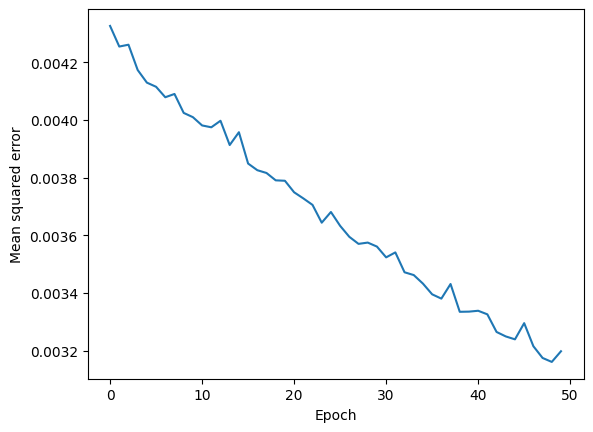

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

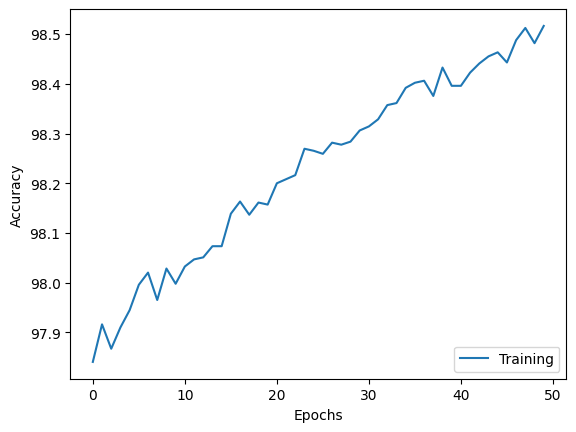

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 96.66%


In [ ]:
one_hot_y_train = int_to_onehot(y_train, 10)
one_hot_y_test = int_to_onehot(y_test, 10)

# Keras Nueral Network Implementation

In [ ]:
# Keras implementation
from keras.layers import Dense, Input, Flatten
from keras.optimizers import Adam
from keras.models import Model, Sequential

In [ ]:
keras_model = Sequential()
keras_model.add(Input(28*28,))
keras_model.add(Dense(50, activation='sigmoid'))
keras_model.add(Dense(50, activation='sigmoid'))
keras_model.add(Dense(10, activation='softmax'))
keras_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
keras_model.fit(X_train, one_hot_y_train, epochs=50)

Epoch 1/50
1532/1532 [==============================] - 4s 2ms/step - loss: 0.6421 - acc: 0.8451
Epoch 2/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.2479 - acc: 0.9272
Epoch 3/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.1908 - acc: 0.9434
Epoch 4/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.1600 - acc: 0.9518
Epoch 5/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.1387 - acc: 0.9580
Epoch 6/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.1262 - acc: 0.9614
Epoch 7/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.1144 - acc: 0.9658
Epoch 8/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.1041 - acc: 0.9680
Epoch 9/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.0982 - acc: 0.9699
Epoch 10/50
1532/1532 [==============================] - 3s 2ms/step - loss: 0.0904 - acc: 0.9715
Epoch 11/50
1532/1532 [======

# Single Layer Nueral Network

In [ ]:
def compute_mse_and_acc_single_layer(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

class NeuralNetMLPOneLayer:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
model_single_layer = NeuralNetMLPOneLayer(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [ ]:
def train_single_layer(model, X_train, y_train, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc_single_layer(model, X_train, y_train)
        train_acc = train_acc*100
        epoch_train_acc.append(train_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% ')

    return epoch_loss, epoch_train_acc

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc = train_single_layer(model_single_layer, X_train, y_train, num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.03 | Train Acc: 87.43% 
Epoch: 002/050 | Train MSE: 0.02 | Train Acc: 88.74% 
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 89.72% 
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 90.27% 
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.87% 
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 91.08% 
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.50% 
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 91.73% 
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.92% 
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.22% 
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.41% 
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.60% 
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.74% 
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.89% 
Epoch: 015/050 | Train MSE: 0.01 | Train Acc: 93.03% 
Epoch: 016/050 | Train MSE: 0.01 | Train Acc: 93.20% 
Epoch: 017/050 | Train MSE: 0.01 | Train Acc: 93.28% 
Epoch: 018/050 | Train MSE: 0.01 | Train Acc: 93.40% 
Epoch: 019/050 | Train MSE: 

# Performance Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score
keras_prediction = keras_model.predict(X_test)
a_h1, a_h2, a_out = model.forward(X_test)
single_ah1, single_out = model_single_layer.forward(X_test)
model_prediction = a_out
single_layer_nn_prediction = single_out

for model_pred in model_prediction:
  model_pred /= sum(model_pred)

for model_pred in single_layer_nn_prediction:
  model_pred /= sum(model_pred)

y_true = y_test

print(f"our model macro auc:{roc_auc_score(y_true, model_prediction, average='macro', multi_class='ovr')}")
print(f"keras model macro auc:{roc_auc_score(y_true, keras_prediction, average='macro', multi_class='ovr')}")
print(f"single layer model macro auc:{roc_auc_score(y_true, single_layer_nn_prediction, average='macro', multi_class='ovr')}")

657/657 [==============================] - 1s 1ms/step
our model macro auc:0.9974894793244623
keras model macro auc:0.9988191517851966
single layer model macro auc:0.993949415669112
